In [1]:
import os
from glob import glob

def load_images(root_dir):
    image_list = []
    
    for folder_name in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
        
        label = folder_name.replace('_', '/')
        
        image_paths = glob(os.path.join(folder_path, '*.*'))
        image_paths = image_paths[:50]
        
        for img_path in image_paths:
            image_list.append({
                "img_path":img_path,
                "label":label
            })
            
    return image_list


root_dir = "dataset\output_frames"
image_label_list = load_images(root_dir)

print(len(image_label_list))

3250


In [12]:
import torch
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# 1. 모델 및 프로세서 준비
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed").to('cuda' if torch.cuda.is_available() else 'cpu')

def predict_trocr(image):
    if type(image) == str:
        image = Image.open(image).convert("RGB")
    else:
        image = Image.fromarray(image).convert("RGB")
    pixel_values = trocr_processor(images=image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(trocr_model.device)
    generated_ids = trocr_model.generate(pixel_values)
    pred = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return pred.strip()


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

In [3]:
import torch
print(torch.__version__)
print(torch.backends)


2.5.1+cu121
<module 'torch.backends' from 'c:\\Users\\minja\\anaconda3\\envs\\TrOCR\\lib\\site-packages\\torch\\backends\\__init__.py'>


오츄 알고리즘으로 결정된 최적 임계값: 138.0


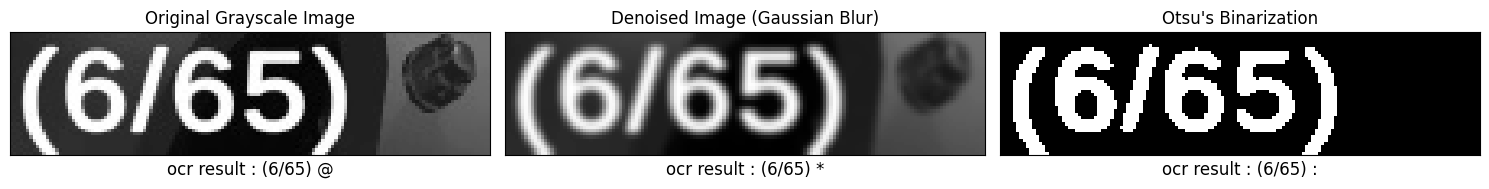

In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- 이미지 불러오기 ---
# 'image.jpg'를 실제 이미지 파일 경로로 변경하세요.
# 이미지를 그레이스케일로 직접 불러옵니다.
image_path = '(1_65)(S)/05670.jpg'
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if gray_image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")


# --- 1. 노이즈 제거 (가우시안 블러) ---
# (5, 5)는 가우시안 커널 크기이며, 이미지 상태에 따라 조절할 수 있습니다.
denoised_image = cv2.GaussianBlur(gray_image, (5, 5), 0)


# --- 2. 적응형 이진화 (오츄 알고리즘) ---
# cv2.THRESH_BINARY: 임계값보다 크면 maxval, 작으면 0으로 설정
# cv2.THRESH_OTSU: 오츄 알고리즘 적용
ret, otsu_binary_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"오츄 알고리즘으로 결정된 최적 임계값: {ret}")

label1 = predict_trocr(gray_image)
label2 = predict_trocr(denoised_image)
label3 = predict_trocr(otsu_binary_image)


# --- 결과 이미지 시각화 ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.xlabel(f"ocr result : {label1}", fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image (Gaussian Blur)')
plt.xlabel(f"ocr result : {label2}", fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(otsu_binary_image, cmap='gray')
plt.title("Otsu's Binarization")
plt.xlabel(f"ocr result : {label3}", fontsize=12)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

In [41]:
import numpy as np
import editdistance

def cer(s1, s2):
    # 문자단위 Levenshtein 거리
    return editdistance.eval(s1, s2) / max(len(s2), 1)

def wer(ref, hyp):
    # 단어단위 Levenshtein 거리
    ref_words = ref.split()
    hyp_words = hyp.split()
    return editdistance.eval(hyp_words, ref_words) / max(len(ref_words), 1)

In [42]:
all_results = []

for item in image_label_list:
    img_path = item["img_path"]
    gt_label = item["label"]
    
    image = cv2.imread(img_path)

    # 2. 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. 가우시안 블러 적용 (커널 사이즈는 5x5)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # 4. 오츄 알고리즘을 사용한 적응형 이진화
    # threshold 값은 _ 변수로 받아 무시하고, 오츄 알고리즘이 최적의 임계값을 자동으로 결정합니다.
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    # 추론 (전처리된 이미지 사용)
    pred_trocr = predict_trocr(binary_image)

    # 추론
    pred_trocr = predict_trocr(img_path)

    # 평가
    cer_t = cer(pred_trocr, gt_label)
    wer_t = wer(pred_trocr, gt_label)

    all_results.append({
        "img": img_path,
        "gt": gt_label,
        "trocr_pred": pred_trocr,
        "cer_trocr": cer_t,
        "wer_trocr": wer_t,
    })


# 평균 CER/WER 계산
trocr_cer = np.mean([r['cer_trocr'] for r in all_results])
trocr_wer = np.mean([r['wer_trocr'] for r in all_results])

print(f"TROCR CER: {trocr_cer:.4f} / WER: {trocr_wer:.4f}")

TROCR CER: 0.0000 / WER: 0.0000
